# Comparison between DLC and Sleap


Sleap provides a couple of small videos at the [sleap repo under the test data folder](https://github.com/talmolab/sleap/tree/develop/tests/data/videos), as well as a sample video from the [sleap datasets repo](https://github.com/talmolab/sleap-datasets) that is more refined and also contains some labels. DeepLabCut provides example videos in their [git repo](https://github.com/DeepLabCut/DeepLabCut/tree/main/examples). For this comparison, we will be using the [example mice video](https://github.com/DeepLabCut/DeepLabCut/blob/main/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi) for this comparison. 

Comparison pipeline: skip prediction-assisted labeling

- Generate some frames to label, train on 80% and test on 20% 
- Train model
- Predict on entire video

Evaluation metrics:

- Pixel error on test labeled frames
- Visualize Predictions Labeled video

### Table of contents

Sleap Training demo

- [Sleap Model training](#SLEAP-TRAINING)
    - [Train-Test Split Preprocessing](#Train-Test-Split-Preprocessing)
    - [Train-Test Split in Terminal](#Train-Test-in-Terminal)
    - [Train-Test Split in GUI](#Train-Test-in-GUI)
- [Sleap Model evaluation in notebook](#SLEAP-EVALUATION)
- [(Optional) Prediction-assisted labeling in Sleap GUI](#(Optional)-Prediction-assisted-labeling-in-GUI)
- [Sleap Predictions post-processing](#SLEAP-PREDICTION-post-processing)
    - [Sleap Generate Prediction video](#SLEAP-Generate-Predictions-Video)
    
    
[Sleap Training with DLC models](#Use-DLC-labels-in-Sleap-Training)

### How to follow this notebook

To follow through this notebook, you must have a sleap conda environment installed as described in the README. Then change the kernel of this notebook to `Python [sleap]`. Now you will be able to run the commands in the notebook within the sleap conda environment. 

In [1]:
import sleap
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

NOTEBOOK_DIR = Path.cwd()
SLEAP_PROJECT_DIR = NOTEBOOK_DIR / "sleap-mouse-topview"
SLEAP_DIR = SLEAP_PROJECT_DIR / "appstream-sleap-compare"
DLC_DIR = SLEAP_PROJECT_DIR / "appstream-dlclabels"
MULTI_COMPARE_DIR = SLEAP_PROJECT_DIR / "appstream-dlclabels-epoch200"
SINGLE_BASELINE_COMPARE_DIR = SLEAP_PROJECT_DIR / "appstream-dlclabels-epoch200-single-baseline"
SINGLE_PRETRAINED_COMPARE_DIR = SLEAP_PROJECT_DIR / "appstream-dlclabels-epoch200-single-pretrained"

This notebook assumes you use the same file structure denoted above, where the SLEAP_DIR is the training job folder for manual labels, and the DLC_DIR is the training job folder for imported DLC labels. These first two folders are used for trial training where the epoch size is small, and the COMPARE_DIR is the training job folder that uses the imported DLC labels and the default training epoch size, whose result will be used for comparison with DLC training. 

The code included in this notebook should be ran in the appstream instance Terminal App, either directly as a terminal command, or in a python console as a python command. However, some code are presented as code blocks in the notebook that you can run for some simple visualizations. 

The exact filenames used in this notebook might not be the same as the ones you generate when following through. If so, substitute correspondingly to use your actual filenames. 

### Some notes on Sleap

Whenever you try to save your labels in the GUI, using `File-Save as` will save to a `.slp` file, which is much smaller a `.pkg.slp` file saved by doing `Predict-Export Labels Package`. However, the `.pkg.slp` file contains both the labels and the video/images used for labeling, hence can be used to run training elsewhere without worring about video paths, whereas the `.slp` file relies on the original video/image source being in place.

This notebook assumes you would do everything in appstream, including both training, prediction, and evaluation. However, only training and prediction would benefit from GPU acceleration, so when the notebook says to create a .slp file, feel free to export a `.pkg.slp` file if you would like to proceed with analysis elsewhere. 

# SLEAP TRAINING

Use the GUI for labeling and prediction-assisted training as you would usually on your local computer. It is easy to do prediction-assisted training and inference in the GUI, although it is certainly doable through the terminal as well. The only complication with the GUI comes  when you would like to do a train-test split, and there are several approaches to do it manually, either through the terminal, the GUI, or the jupyter notebook. 

Train-test split is tricky in Sleap becuase by default all labeled frames will be used for training. Suppose we generate 20 suggested frames, then we want to use 16 of them for training and 4 of them for testing. The default validation fraction is 0.1, which means that 0.1 of the training frames (i.e. 2 frames in this case) will not be used for training directly, instead will be used for tuning hyperparameters and early stopping. Model metrics would be generated based on its performance on the 4 testing frames. [(See train config file documentation)](https://sleap.ai/develop/api/sleap.nn.config.data.html#sleap.nn.config.data.LabelsConfig)

- Training labels: used for training
- Validation labels: not used for training, used for hyperparameters and early stopping, default sample 0.1 from training labels
- Test labels: not used for training, used for benchmarking

The following instructions use the top-down training pipeline with reduced number of training epochs (10 epoch per model) for demo purposes. See the section on [Sleap training with DLC labels](#Use-DLC-labels-in-Sleap-Training) for training with the default number of training epochs. 

## Train-Test Split Preprocessing

Since Sleap does not provide a native train-test split in the GUI, we need to generate separate train and test label files manually. The steps here show you how to create these two files from a raw video file, but if you have a labeled `.slp` file provided, you can split it into two train and test files using the procedure detailed in the [section on importing DLC data](#Use-DLC-labels-in-Sleap-Training-(in-progress)).

First, create a folder inside the Home Folder to store all SLEAP related files for this project, for example `sleap-mouse-topview`. Then open the SLEAP GUI. 

- Generate 20 frames and save as `labels.20frames.slp` file, where 16 will be training frames and 4 will be testing frames. 
- Open a new project in the GUI using the `labels.20frames.slp` file, label 4 frames, and `Predict-Export Label Package` to a `labels.20frames4labeled.pkg.slp` file in Home Folder.
- In the same project, click the `Labeling Suggestions` panel and click on the `Labels` column in the table to organize by labels. Scroll to the labeled frames and one by one, delete the labeled instance in the `Instances` panel and remove the suggestion in the `Labeling Suggestions` panel. Now you are left with 16 suggested frames. 
- Label the remaining 16 frames, and `Predict-Export Label Package` to a `labels.20frames16labeled.slp` file in Home Folder. 
- In the same project, click `Predict-Run Training` in the toolbox, and mofidify train configurations.
    - This demo used the "baseline.centroid" and "baseline_medium_rf.centered_instance" config files, and then configured 10 epoch for each model
    - Then select predict on Nothing, set run prefix to "appstream_train16_test4"
- DO NOT click run training. Instead, click `Export Training Job` and save the zip file to the sleap project folder with a descriptive name. This will be the training job folder name (e.g. `labels.appstream0inference20frames16labeled.slp.training_job`)

Go to Appstream's home folder and unzip the training job folder, rename folder to `appstream-sleap-compare`. It should contain a `labels.20frames16labeled.pkg.slp` file and some training job config files. Move the `labels.20frames4labeled.pkg.slp` file into this folder as well.

NOTE: Save labels via `Predict - Export Labels` and not `File - Save As` if you want to use them elsewhere (e.g. on local computer). If directly Save As .. in GUI after labeling, the labeled frames in the `.slp` file will reference the original video file with its appstream location, which wouldn't be available if you moved the files. However, if saved via Export Labels, the labeled frames in the `.pkg.slp` file will only reference the `.pkg.slp` file itself.

In [6]:
!dir $SLEAP_DIR

 Volume in drive C is Windows
 Volume Serial Number is 2E94-A0A3

 Directory of C:\Users\louise.xu\projects\scicomp-summer-project\sleap-mouse-topview\appstream-sleap-compare

07/27/2023  02:54 PM    <DIR>          .
07/27/2023  02:54 PM    <DIR>          ..
07/26/2023  02:57 PM             5,891 centered_instance.json
07/26/2023  02:57 PM             5,761 centroid.json
07/26/2023  02:57 PM                13 inference-script.sh
07/26/2023  02:57 PM               344 jobs.yaml
07/26/2023  02:57 PM         1,428,520 labels.20frames16labeled.pkg.slp
07/26/2023  02:57 PM           386,864 labels.20frames4labeled.pkg.slp
07/26/2023  12:00 PM            42,681 labels.fromdlc.slp
07/27/2023  02:54 PM    <DIR>          models
07/25/2023  10:26 AM            88,449 mouse-labels.h5
07/27/2023  04:55 PM           231,004 sleap-mouse-predictions.csv
07/25/2023  11:33 AM           834,508 sleap-mouse-topview-video.predictions-only-relabels-gui.pkg.slp
07/26/2023  02:57 PM            18,192 sleap-m

### Train-Test in Terminal

Follow the pre-processing steps and create the `appstream-sleap-compare` training job folder. Change directory to training job folder, then in terminal, run 

    sleap-train centroid.json labels.20frames16labeled.pkg.slp --test labels.20frames4labeled.pkg.slp && sleap-train centered_instance.json labels.20frames16labeled.pkg.slp --test labels.20frames4labeled.pkg.slp
    
Models will be generated under the training job folder in `sleap-mouse-topview/appstream-sleap-compare/models`. 

### Train-Test in GUI

Follow the pre-processing steps to create a training job folder. Change directory to training job folder, and modify both json files so that the training label and test labels paths point to the `.pkg.slp` files saved in the folder. 

```
"training_labels": "D:/PhotonUser/My Files/Home Folder/sleap-mouse-topview/appstream_modifyjson/labels.20frames16labeled.pkg.slp",
"validation_labels": null,
"validation_fraction": 0.1,
"test_labels": "D:/PhotonUser/My Files/Home Folder/sleap-mouse-topview/appstream_modifyjson/labels.20frames4labeled.pkg.slp",
```

Use these json config files in the GUI train configurations window, and proceed with training in the GUI. 

Models will be generated under the project folder in `sleap-mouse-topview/models`. 

## SLEAP EVALUATION

You can analyze the performance of the trained models using the metrics available in the model files. You can follow the steps below in a jupyter notebook or in a similar python environment. If you would like to export resulting model files for analysis somewhere else, run `tar -acf out.zip /path/to/models`, or zip the models directory using File Explorer, then download the zip file to your local computer. Check [ReadMe](./README.md) for instructions on downloading files on AppStream. 

Here is an example view of what the models folder should contain. If you want to analyze the centroid model, go to `models\appstream_noinference_train16_test4230721_210307.centroid`. The test pixel error is available in the `metrics.test.npz` file. 

In [8]:
MODELS_DIR = SLEAP_DIR / "models"
CENTROID_MODEL = MODELS_DIR / "appstream_noinference_train16_test4_fromscript230721_210307.centered_instance"

!dir $CENTROID_MODEL

 Volume in drive C is Windows
 Volume Serial Number is 2E94-A0A3

 Directory of C:\Users\louise.xu\projects\scicomp-summer-project\sleap-mouse-topview\appstream-sleap-compare\models\appstream_noinference_train16_test4_fromscript230721_210307.centered_instance

07/27/2023  02:54 PM    <DIR>          .
07/27/2023  02:54 PM    <DIR>          ..
07/26/2023  02:57 PM        69,145,416 best_model.h5
07/26/2023  02:57 PM             5,975 initial_config.json
07/26/2023  02:57 PM            18,040 labels_gt.test.slp
07/26/2023  02:57 PM            20,088 labels_gt.train.slp
07/26/2023  02:57 PM            18,040 labels_gt.val.slp
07/26/2023  02:57 PM            15,944 labels_pr.test.slp
07/26/2023  02:57 PM            16,448 labels_pr.train.slp
07/26/2023  02:57 PM            15,944 labels_pr.val.slp
07/26/2023  02:57 PM             2,147 metrics.test.npz
07/26/2023  02:57 PM             2,471 metrics.train.npz
07/26/2023  02:57 PM             1,991 metrics.val.npz
07/26/2023  02:57 PM        

Here is how you can load the model metrics for different splits, i.e. train, validation, and test. For this comparison, we are mainly interested in the text pixel error. The [Model Evaluation guide](https://sleap.ai/develop/notebooks/Model_evaluation.html) contains more information on the different model metrics available. 

In [10]:
#help(sleap.load_metrics)
metrics_test = sleap.load_metrics(CENTROID_MODEL, split="test")

print("====model metrics on test split====")
print("mAP:", metrics_test["oks_voc.mAP"])
print("pixel error:", metrics_test["dist.avg"])
print("Error distance (50%):", metrics_test["dist.p50"])
print("Error distance (90%):", metrics_test["dist.p90"])
print("Error distance (95%):", metrics_test["dist.p95"])

====model metrics on test split====
mAP: 0.06386138613861386
pixel error: 32.214755664959654
Error distance (50%): 5.36766396864419
Error distance (90%): 115.05192635664173
Error distance (95%): 118.88547845449584


## SLEAP PREDICTION

To run inference on the entire video using the trained models, you can also choose to continue from the terminal or the GUI. 

To continue from the terminal, make sure you are in the training job folder, then run the following command. If you would like to run inference on a selected portion of frames, you need to specify the path to a `.slp` labels file instead. See [documentation on sleap-track](https://sleap.ai/develop/guides/cli.html#inference-and-tracking) for more details.

    sleap-track C:\s3-mount\dlc-sample-videos\mouse-movement-videos\mouse-top-view.mp4 
        -m models\appstream_noinference_train16_test4_fromscript230721_210307.centroid 
        -m models\appstream_noinference_train16_test4_fromscript230721_210307.centered_instance 
        -o sleap-mouse-topview-video.predictions.slp
        
 

To continue from the GUI, click `Predict-Run Inference` and make sure it is using the config files of the model you just trained (usually selected by default). Then proceed with inference on the entire video or your choice of frames. 

## (Optional) Prediction-assisted labeling in GUI

Suppose you have a `predictions.slp` file in the training job folder, and you open it in the GUI to correct predicted frames that are incorrect. Save file as `predictions-relabeled.slp` or file in training job folder.  

You could continue the training process in the GUI (method 1), or extract a .slp file with the user-labeled corrections. You can extract the corrections via the GUI (method 2) or via the Sleap API (method 3). After extracting the .slp file, you may repeat the training and predicting process as denoted above in [SLEAP TRAINING](#SLEAP-TRAINING) and [SLEAP PREDICTION](#SLEAP-PREDICTION).

- Method 1: In GUI, click `Predict-Run Training`, the retrained models will be generated under training job folder in `sleap-mouse-topview/appstream-sleap-compare/models`. 

- Method 2: In Sleap GUI toolbar, click `Delete All Predictions...` to delete all predicted instances and be left with user-labeled corrections only. Save the corrected labels to another `predictions-only-relabels.slp` file. You may want to open another project with some labeled frames and merge in these corrected frames using `Fiels-Merge Data From` to continue training. See more documentation on [merging](https://sleap.ai/develop/guides/merging.html). 

- Method 3: You may also use the following python code to generate the `predictions-only-relabels-terminal.slp` file with only user-labeled corrections, then run training in the terminal as demonstrated in [SLEAP TRAINING](#SLEAP-TRAINING).

        labels = sleap.load_file('sleap-mouse-topview-video.predictions-relabeled.slp')
        only_relabels = labels.with_user_labels_only()
        only_relabels.save("sleap-mouse-topview-video.predictions-only-relabels-terminal.slp")

P.S. When using the Sleap API open the `predictions-only-relabels.slp` file created via the GUI (as shown below), you may notice that it contains more labeled frames than expected. Don't panic, it is probably due to extra empty frames. Remove the empty frames and you will notice that the number of labeled frames is the same as the number of frames you corrected previously. So you can run training on this file with no problem as the empty frames will automatically be ignored during training. 

In [7]:
%cd $SLEAP_DIR
relabel = sleap.load_file(str(SLEAP_DIR / "sleap-mouse-topview-video.predictions-only-relabels.slp"))
print(relabel)
relabel.remove_empty_frames()
print(relabel)

C:\Users\louise.xu\projects\scicomp-summer-project\sleap-mouse-topview\appstream-sleap-compare
Labels(labeled_frames=24, videos=1, skeletons=1, tracks=0)
Labels(labeled_frames=7, videos=1, skeletons=1, tracks=0)


## SLEAP PREDICTION post-processing

You can also directly process the predictions made on the entire video using the `predictions.slp` file. Here is a quick view of what data it contains, but we will convert it into a .h5 file later for easier analysis. 

In [8]:
predictions = sleap.load_file(str(SLEAP_DIR / "sleap-mouse-topview-video.predictions.slp"))
print("predictions: ", predictions)
print()
print("first prediction instance: ")
print(predictions.predicted_instances[0])
print()
print("first prediction coordinates and score: ")
print(predictions.predicted_instances[0].points_and_scores_array)
print()
print("first prediction coordinates: ")
print(predictions.predicted_instances[0].numpy())

predictions:  Labels(labeled_frames=2330, videos=1, skeletons=1, tracks=0)

first prediction instance: 
PredictedInstance(video=Video(filename=C:\s3-mount\dlc-sample-videos\mouse-movement-videos\mouse-top-view.mp4, shape=(None, None, None, None), backend=MediaVideo), frame_idx=0, points=[head: (77.0, 88.6, 1.02), tailBase: (140.4, 187.7, 0.95)], score=0.94, track=None, tracking_score=0.00)

first prediction coordinates and score: 
[[ 76.97714233  88.58641815   1.02416515]
 [140.41918945 187.72146606   0.94858468]]

first prediction coordinates: 
[[ 76.97714233  88.58641815]
 [140.41918945 187.72146606]]


Run the following code in a python terminal to convert convert .slp files into .h5 files.

    sleap-convert "sleap-mouse-topview-video.predictions.slp" --format analysis --output mouse-labels.h5

In [11]:
%cd $SLEAP_DIR
filename = "mouse-labels.h5" # or your own exported filename

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations (tracks) data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

C:\Users\louise.xu\projects\scicomp-summer-project\sleap-mouse-topview\appstream-sleap-compare
===filename===
mouse-labels.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations (tracks) data shape===
(2330, 2, 2, 1)

===nodes===
0: head
1: tailBase



You can also make a `.csv` file containing the predicted locations from the `.h5` file. This may useful if you would like to import this into DeepLabCut (progress in this is currently [blocked](./Compare_DLC.ipynb#Format-Sleap-Predictions-for-DLC-Visualiztaion-(blocked))). 

In [14]:
locations_csv = locations.reshape((2330, 4))
header= ""
for name in node_names:
    header += name + "-x, " + name + "-y, "
np.savetxt( "sleap-mouse-predictions.csv", locations_csv, delimiter=",", header=header, comments="")

### SLEAP Generate Predictions Video

Once you have the `predictions.slp` file containing predictions of the entire video, you can generate a video file visualizing these prediction instances. 

Method 1 (GUI): Open the `predictions.slp` file. In the GUI toolbar, click `View-Render Video Clip with Instances...`. 

Method 2 (Terminal): Change to the directory containing the `predictions.slp` file. Then enter the following command. I set the fps to be 30, the same as the sample video fps value. Note that the output name must contain a valid extension such as `.avi`

    sleap-render predictions.slp --fps 30 --output predictions-video.avi

I did both methods to create a `predictions-video-gui.avi` file and a `predictions-video-terminal.avi` file, with the previous one being only slightly higher bitrate (537kbps vs 533kbps). 

# Use DLC labels in Sleap Training

You can click `File-Import-DeepLabCut dataset` to import a DeepLabCut `.csv` file containing the user label coordinates. This will open a Sleap GUI window containing only the labeled video frames. Use `File-Save as` to save this as a `labels.fromdlc.slp` file. 

### Train on DLC labels

Open `sleap-mouse-topview/labels.fromdlc.slp` file which only contains 113 frames. Generate 23 random suggestions to be test frames, delete the instances in these frames and save to a `sleap-mouse-topview/train.slp` file. 

- Keyboard shortcut to delete these frames: Space = Next suggestion frame. Click on the mouse in the video image preview to select the instance. Control + SHift + Backspace = Delete selected instance. 

Then configure the training parameters and export a training job package `labels.fromdlc.train.slp.training_job`. Extract the zip file into a directory with a descriptive name, for example `appstream-dlclabels`. 

Next, change to the training job directory and start creating a test label frames file by removing the training label frames from the imported label frames using the code below. You may load either .slp or .pkg.slp files during this step, the difference isn't significant. You can choose to create a `test.slp` file or a `test.pkg.slp` file by modifying the `with_images` flag. 

    dlc_labels_test = sleap.load_file("../labels.fromdlc.slp")
    dlc_labels_train = sleap.Labels.load_file("../labels.fromdlc.train.slp", match_to=dlc_labels_test)
    dlc_labels_train.remove_empty_frames()
    dlc_labels_test.remove_user_instances(new_labels=dlc_labels_train)
    dlc_labels_test.save("labels.fromdlc.test.slp")
    #dlc_labels_test.save("labels.fromdlc.test.pkg.slp", with_images=True)

Unzip the training job package folder and move the `test.slp` file into this folder. Next proceed to training as illustrated below, similar to [SLEAP TRAINING](#SLEAP-TRAINING). 
    
    sleap-train centroid.json labels.fromdlc.train.pkg.slp --test labels.fromdlc.test.slp && sleap-train centered_instance.json labels.fromdlc.train.pkg.slp --test labels.fromdlc.test.slp

Then run predictions on the video using the following command, and create the prediction video using steps similar to the [prediction video generation section](#SLEAP-Generate-Predictions-Video). 

    sleap-track C:\s3-mount\dlc-sample-videos\mouse-movement-videos\mouse-top-view.mp4 -m models\appstream-sleap-dlclabels-epoch200-230728_002222.centroid -m models\appstream-sleap-dlclabels-epoch200-230728_002222.centered_instance -o sleap-mouse-topview-video.predictions.slp

### Train Results

For comparison purposes, I repeated the above procedure except modifying the training configurations to use the single training pipeline, using either the "baseline.json" config file or the "pretrained.json" config file. Two training jobs are created and saved in folders `appstream-dlclabels-epoch200-single-baseline` and `appstream-dlclabels-epoch200-single-pretrained`. Copy the `labels.fromdlc.test.dlp` file created in the steps above into these folders. Then change directory to these training job folders respectively to run the following commands:

    # For single-basline
    sleap-train single_instance.json labels.fromdlc.train.pkg.slp --test labels.fromdlc.test.slp 
    sleap-track C:\s3-mount\dlc-sample-videos\mouse-movement-videos\mouse-top-view.mp4 -m models\appstream-dlc-labels-single-baseline230731_225111.single_instance -o sleap-mouse-topview-video.predictions.slp
    
    # For single-pretrained
    sleap-train single_instance.json labels.fromdlc.train.pkg.slp --test labels.fromdlc.test.slp 
    sleap-track C:\s3-mount\dlc-sample-videos\mouse-movement-videos\mouse-top-view.mp4 -m models\appstream-dlc-labels-single-pretrained230731_225241.single_instance -o sleap-mouse-topview-video.predictions.slp
    

### Train Results

Top-down training pipeline with default 200+200 epochs: 

- Centroid model stopped early after 75 epochs, ran for 16 min
- Centered instance model stopped early after 44 epochs, ran for 13 min
- Overall ran for 29 min over 119 epochs, on average around 15s per epoch. 

Single training pipeline (baseline config) with default 200 epochs:

- Model training stopped early after 47 epochs, ran for 26 min
- Overall, on average around 33s per epoch

Single training pipeline (pretrained config) with default 200 epochs:

- Model training stopped early after 61 epochs, ran for 3.25h
- TODO: Rerun to confirm run time

### Evaluation Results

In [13]:
MODELS_DIR = MULTI_COMPARE_DIR / "models"
CENTROID_MODEL = MODELS_DIR / "appstream-sleap-dlclabels-epoch200-230728_002222.centroid"
CENTERED_INSTANCE_MODEL = MODELS_DIR / "appstream-sleap-dlclabels-epoch200-230728_002222.centered_instance"
metrics_centroid = sleap.load_metrics(CENTROID_MODEL, split="test")
metrics_centered_instance = sleap.load_metrics(CENTERED_INSTANCE_MODEL, split="test")

print("====centroid====")
print("pixel error:", metrics_centroid["dist.avg"])
print()

print("====centered_instance====")
print("pixel error:", metrics_centered_instance["dist.avg"])

====centroid====
pixel error: 5.676117925406821e-06

====centered_instance====
pixel error: 2.3569659024927754


In [5]:
BASELINE_MODEL = SINGLE_BASELINE_COMPARE_DIR / "models" / "appstream-dlc-labels-single-baseline230731_225111.single_instance"
metrics_baseline = sleap.load_metrics(BASELINE_MODEL, split="test")

PRETRAINED_MODEL = SINGLE_PRETRAINED_COMPARE_DIR / "models" / "appstream-dlc-labels-single-pretrained230731_225241.single_instance"
metrics_pretrained = sleap.load_metrics(PRETRAINED_MODEL, split="test")

print("====baseline====")
print("pixel error:", metrics_baseline["dist.avg"])
print()

print("====pretrained====")
print("pixel error:", metrics_pretrained["dist.avg"])
print()

====baseline====
pixel error: 1.9640484923805497

====pretrained====
pixel error: 2.206363971739771



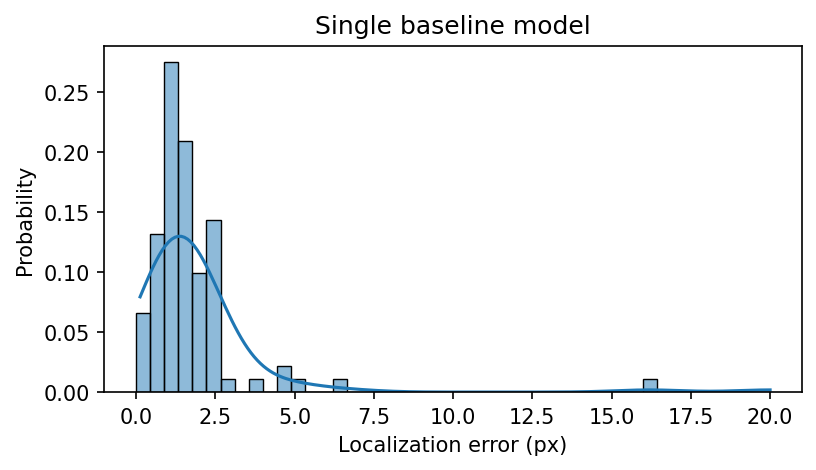

In [16]:
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics_baseline["dist.dists"].flatten(), binrange=(0, 20), kde=True, kde_kws={"clip": (0, 20)}, stat="probability")
plt.xlabel("Localization error (px)")
plt.title("Single baseline model")
plt.show()

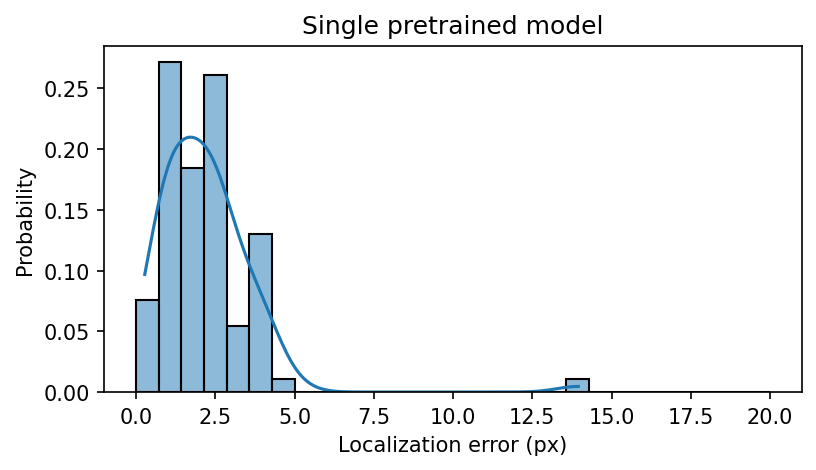

In [17]:

plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics_pretrained["dist.dists"].flatten(), binrange=(0, 20), kde=True, kde_kws={"clip": (0, 20)}, stat="probability")
plt.xlabel("Localization error (px)")
plt.title("Single pretrained model")
plt.show()

### Merge DLC labels into Sleap project (blocked)

Next open a new Sleap project and load the raw video file. Then click `File-Merge into Project` to merge the `labels.fromdlc.slp` file into the current project. 

- Run into error during merge : "Labels.skeleton can only be used when there is only a single skeleton saved in the labels. Use Labels.skeletons instead."

# Format DLC predictions for Sleap evaluation and visualization (in progress)

Either evaluate separately, or import DLC predictions into Sleap to evaluate model and visualize result. 

Import Predictions CSV error: ValueError: Skeleton already has a node named (head)

    - Possible reason: csv has extra column likelihood
    - Solution: try to export csv in dlc in previous format, try deeplabcut.create_labeled_data()